In [31]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Dropout, Bidirectional, Activation
from sklearn.model_selection import train_test_split

In [39]:
# Initialize variables
seq_len = 100
dropout = 0.2
batch_size = 64
epochs = 100
prediction_length = 1
window_size = seq_len - prediction_length

In [33]:
# Import data using pandas
df = pd.read_csv('bitcoin_data_2_hr.csv')
price_array = df['close'].to_numpy()
price_array = price_array.reshape(-1, 1)

In [41]:
# Preprocess data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
price_array = scaler.fit_transform(price_array)

# Make sequences of 100 previous values and take the next value as the target
d = []
for index in range(len(price_array) - seq_len):
    d.append(price_array[index: index + seq_len])
d = np.array(d)
d = d.reshape((d.shape[0], d.shape[1], 1))

x_data = d[:, :-prediction_length, :]
y_data = d[:, -prediction_length:, :]

In [42]:
# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.1, shuffle=False)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3759, 188, 1) (418, 188, 1) (3759, 12, 1) (418, 12, 1)


In [43]:
# Create and fit the LSTM network
model = Sequential()
model.add(
    Bidirectional(CuDNNLSTM(units=window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1])))
model.add(Dropout(dropout))

model.add(Bidirectional(CuDNNLSTM(units=window_size * 2, return_sequences=True)))
model.add(Dropout(dropout))

model.add(Bidirectional(CuDNNLSTM(units=window_size, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

print(model.summary())

model.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 188, 376)         287264    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 188, 376)          0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 188, 752)         2268032   
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 188, 752)          0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 376)              1416768   
 onal)                                                           
                                                      

In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2,
                    shuffle=False)

In [15]:
# Make predictions
y_hat = model.predict(X_test)

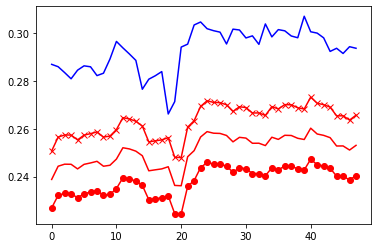

In [16]:
# Plot the predictions
plt.plot(Y_test, label='Actual', color='blue')
plt.plot(0.95 * y_hat, label='Predicted', color='red', marker='o')
plt.plot(y_hat, label='Predicted', color='red')
plt.plot(1.05 * y_hat, label='Predicted', color='red', marker='x')
plt.show()

In [20]:
model.save('bitcoin_model.h5')

In [23]:
from pickle import dump
dump(scaler, open('bitcoin_scaler.pkl', 'wb'))